In [ ]:
library(rio)
library(tidyverse)
library(smwrData)
library(smwrBase)
library(smwrGraphs)
library(scales)

In [ ]:
# Load ggplot theme
source("../../GLab_ggplot2_theme/glab_theme.r")

# Load all helper functions
loaded_scripts = sapply(list.files("../R/", full.names=TRUE), source)

In [3]:
PROJECT_NAME = "ARG23"

DATA_DIR = file.path(
    "../data/",
    PROJECT_NAME
)

## Decription of the input files

* **DIC data** - *ARG23.xlsx*

* **Alkalinity data** - *ARG23_dataset.xlsx*

* **IC data** - *Anioni_Cationi_ARG23.xlsx*

* **ICP-MS data** - *ARG23_dil1at10.xlsx*

## DIC analysis

In [4]:
dic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23.xlsx"
    ),
    skip=4
)

dic_df = dic_df %>%
    # Drop NA rows
    drop_na(Name) %>%
    # Format "Sample Type"
    mutate(`Sample Type`=str_replace_all(
            string=`Sample Type`,
            pattern="\\(|\\)",
            replacement=""
        )
    ) %>%
    # Convert to numeric
    mutate(
        `Height (nA)`=as.numeric(`Height (nA)`),
        `δ¹³C (Gas)`=as.numeric(`δ¹³C (Gas)`)
    ) %>%
    # Group by name and calculate the mean
    group_by(Name) %>%
    summarise(
        Height_mean=mean(`Height (nA)`),
        DeltaC13_mean=mean(`δ¹³C (Gas)`),
        DeltaC13_sd=sd(`δ¹³C (Gas)`) # TODO: check use of SE
    )

dic_df = dic_df %>%
    # Natural sort by name
    slice(stringr::str_order(dic_df$Name, numeric=TRUE)) %>%
    # Transform to factor for plotting the samples in the correct order
    mutate(Name=factor(Name, levels=Name))

dic_df

Name,Height_mean,DeltaC13_mean,DeltaC13_sd
<fct>,<dbl>,<dbl>,<dbl>
ARG23_1,6.4190218,-3.4409935,0.1359016
ARG23_2,4.0301275,-5.5271253,0.2716068
ARG23_3,5.4543274,-3.1768285,0.8068695
ARG23_4,3.5758961,-9.9798606,0.4742499
ARG23_5,1.8756161,-5.9922322,0.7973183
ARG23_6,12.8719853,-2.6227354,0.5387774
ARG23_7,1.4093049,-6.6174893,0.7180623
ARG23_8,4.7544556,-5.8113600,0.2032612
ARG23_9,2.6648682,-4.2482822,0.1525767


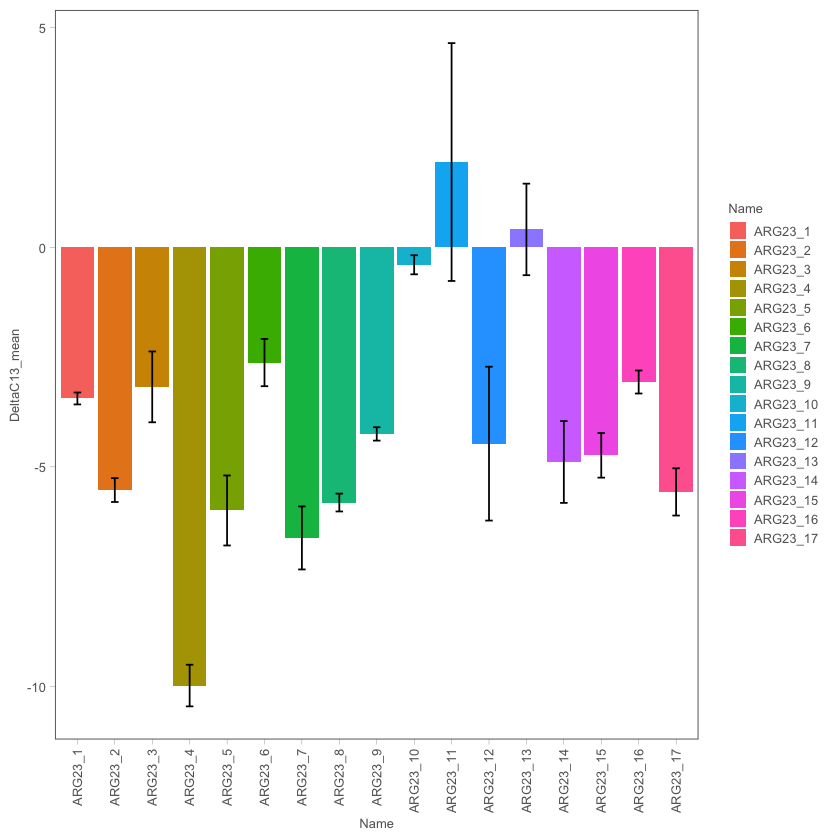

In [5]:
plot_dic = ggplot(
        data=dic_df,
        aes(
            x=Name,
            y=DeltaC13_mean,
            fill=Name
        )
    ) +
    geom_col() +
    geom_errorbar(
        aes(
            ymin=DeltaC13_mean - DeltaC13_sd,
            ymax=DeltaC13_mean + DeltaC13_sd
        ),
        width=.2
    ) +
    theme_glab() +
    # Rotate X axis labels
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

plot_dic

## IC analysis

In [6]:
sample_ids = c(
    "BF",
    "CM",
    "CZ",
    "ES",
    "JB",
    "LB",
    "LF",
    "LN",
    "LV",
    "OY",
    "OZ",
    "PI",
    "PQ",
    "QH",
    "RC1",
    "TZ",
    "VA"
)

In [7]:
ic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG_23.csv"
    )
)
ic_df = process_ic_data(ic_df)

# Select samples
ic_df = ic_df %>% filter(ID %in% sample_ids)
ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,Ammonium,Potassium,Magnesium,Calcium
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BF,NA,1.00,1.870,NA,NA,2.216,NA,18.806,27.603,0.028,3.461,4.520,33.153
CM,NA,1.00,183.920,NA,0.213,NA,NA,353.485,NA,310.184,1.672,0.099,15.612
CZ,NA,9.98,89.249,NA,NA,NA,NA,26.656,175.147,0.472,3.440,3.820,23.274
ES,NA,49.94,3805.285,NA,NA,NA,NA,1920.534,3413.427,2.503,51.482,23.053,147.261
JB,NA,9.96,134.659,NA,NA,NA,NA,192.232,167.601,0.607,19.613,18.879,66.266
LB,NA,98.96,8426.104,NA,NA,10581.428,NA,1139.520,5489.607,14.688,18.095,71.350,341.678
LF,NA,96.63,2325.151,NA,NA,NA,NA,NA,1701.202,13.009,47.645,31.021,145.921
LN,NA,10.09,83.306,NA,NA,6.532,NA,48.850,407.591,0.219,15.718,3.493,40.969
LV,NA,175.27,22700.545,NA,22.374,NA,NA,1947.880,10966.267,10.495,736.896,821.218,1003.251


In [8]:
# Add bicarbonate data
bicarb_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dataset.xlsx"
    ),
    sheet="env_data"
)
bicarb_df = bicarb_df %>%
    select(ID, hco3) %>%
    rename(Bicarbonate=hco3)

ic_df = left_join(
    x=ic_df,
    y=bicarb_df,
    by="ID"
)

# Calculate meq for plotting
ic_df = ic_df %>%
    # WARNING: concentrations must be in mg/L!!!
    mutate(
        HCO3.meq=conc2meq(Bicarbonate, "bicarb"),
        Cl.meq=conc2meq(Chloride, "chloride"),
        SO4.meq=conc2meq(Sulfate, "sulfate"),
        Na.meq=conc2meq(Sodium, "sodium"),
        K.meq=conc2meq(Potassium, "potassium"),
        Ca.meq=conc2meq(Calcium, "calcium"),
        Mg.meq=conc2meq(Magnesium, "magnesium")
    )

ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,⋯,Magnesium,Calcium,Bicarbonate,HCO3.meq,Cl.meq,SO4.meq,Na.meq,K.meq,Ca.meq,Mg.meq
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BF,NA,1.00,1.870,NA,NA,2.216,NA,18.806,27.603,⋯,4.520,33.153,164.70,2.6994330,0.0527527,0.3915409,1.2007305,0.08853238,1.6543347,0.37195080
CM,NA,1.00,183.920,NA,0.213,NA,NA,353.485,NA,⋯,0.099,15.612,124.44,2.0395716,5.1883832,7.3595577,NA,0.04276976,0.7790388,0.00814671
CZ,NA,9.98,89.249,NA,NA,NA,NA,26.656,175.147,⋯,3.820,23.274,380.64,6.2386896,2.5177143,0.5549779,7.6188945,0.08799520,1.1613726,0.31434780
ES,NA,49.94,3805.285,NA,NA,NA,NA,1920.534,3413.427,⋯,23.053,147.261,933.30,15.2967870,107.3470898,39.9855179,148.4840745,1.31690956,7.3483239,1.89703137
JB,NA,9.96,134.659,NA,NA,NA,NA,192.232,167.601,⋯,18.879,66.266,300.12,4.9189668,3.7987304,4.0022702,7.2906435,0.50170054,3.3066734,1.55355291
LB,NA,98.96,8426.104,NA,NA,10581.428,NA,1139.520,5489.607,⋯,71.350,341.678,1006.50,16.4965350,237.7003938,23.7248064,238.7979045,0.46287010,17.0497322,5.87139150
LF,NA,96.63,2325.151,NA,NA,NA,NA,NA,1701.202,⋯,31.021,145.921,1134.60,18.5960940,65.5925097,NA,74.0022870,1.21875910,7.2814579,2.55271809
LN,NA,10.09,83.306,NA,NA,6.532,NA,48.850,407.591,⋯,3.493,40.969,1024.80,16.7964720,2.3500623,1.0170570,17.7302085,0.40206644,2.0443531,0.28743897
LV,NA,175.27,22700.545,NA,22.374,NA,NA,1947.880,10966.267,⋯,821.218,1003.251,808.86,13.2572154,640.3823744,40.5548616,477.0326145,18.84979968,50.0622249,67.57802922


#### Giggenbach diagram

In [9]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-giggenbach-cations-plot.png")
    ),
    width=7,
    height=7
)

plot_base_gigg_cations() +
    geom_point(
        data=ic_df,
        aes(fill=ID),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()
 
graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-giggenbach-cations-plot.png"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


In [10]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-giggenbach-anions-plot.png")
    ),
    width=7,
    height=7
)

plot_base_gigg_anions() +
    geom_point(
        data=ic_df,
        aes(
            x=SO4.meq,
            y=Cl.meq,
            z=HCO3.meq,
            fill=ID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()
 
graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-giggenbach-anions-plot.png"


Warning message in geom_segment(data = lines, aes(x = x, y = y, z = z, xend = xend, :
“Ignoring unknown aesthetics: z and zend”
Warning message in geom_point(data = ic_df, aes(x = SO4.meq, y = Cl.meq, z = HCO3.meq, :
“Ignoring unknown aesthetics: z”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


#### Langelier-Ludwig diagram

In [10]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-langelier-ludwig-plot.png")
    ),
    width=7,
    height=7
)

plot_ll(ic_df) +
    theme_glab()

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-langelier-ludwig-plot.png"


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


#### Piper diagram

In [11]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-piper-plot.png")
    ),
    width=7,
    height=7
)

smwrGraphs::piperPlot(
        xCat=ic_df$Ca.meq,
        yCat=ic_df$Mg.meq,
        zCat=ic_df$Na.meq,
        xAn=ic_df$Cl.meq,
        yAn=ic_df$HCO3.meq,
        zAn=ic_df$SO4.meq,
        Plot=list(
            name=ic_df$ID,
            color=setColor(hue_pal()(length(unique(ic_df$ID))))
        ),
        zCat.title="Sodium",
        xAn.title="Chloride",
        yAn.title="Bicarbonate"
    ) %>%
    addExplanation(
        where="ul",
        title="Piper diagram"
    )

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-piper-plot.png"


## ICP-MS analysis

In [ ]:
icp_df = process_icp_data(
    file.path(
        DATA_DIR,
        "ARG23_dil1at10.xlsx"
    )
)

Warning message:
“Removed 132 rows containing missing values (`position_stack()`).”


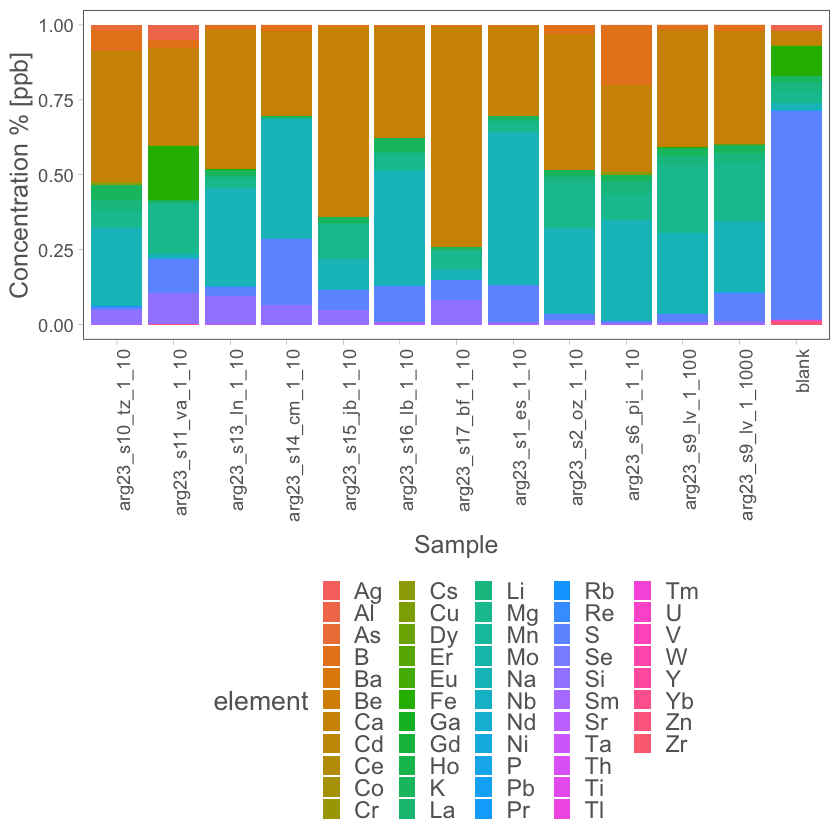

In [13]:
plot_metals = ggplot(
        data=icp_df,
        aes(fill=element, y=concentration, x=sample)
    ) +
    geom_bar(position="fill", stat="identity") +
    theme_glab() +
    theme(
        axis.text=element_text(size=11),
        axis.text.x=element_text(angle=90, hjust=1),
        # axis.ticks.x=element_line(vjust=5),
        strip.text.x=element_text(size=20),
        legend.position="bottom", 
        legend.text=element_text(size=14),
        legend.title=element_text(size=16),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank(),
        panel.background=element_blank(),
        axis.title=element_text(
            size=15,
            color=rgb(100, 100, 100, maxColorValue = 255)
        ),
        axis.title.x=element_text(vjust=-0.5)
    ) +
    xlab("Sample") +
    ylab("Concentration % [ppb]")

plot_metals